In [1]:
import tensorflow as tf
import numpy as np

Архитектура тут следующая:
- 13-мерный вход подаётся двухслойному LSTM
- Выходы второго слоя линейно преобразуются к 80-мерному вектору, от которого берётся softmax
- По этим весам берётся линейная комбинация из истории
Такая схема быстро обучилась задаче копирования. Также к решению сошёлся эволюционной алгоритм (но пока что всё дифференцируемо и хорошо, так что пока без него).

Нам, однако, хочется взятый из истории материал а) преобразовать б) возможно, не использовать, а использовать входы. Поэтому дальше:
- вытащенный из истории вектор объединяется с текущем входом и подаётся на вход ещё одному слою LSTM
- выход LSTM линейно преобразуется к размерности ответа
- в качестве функции потерь в этих экспериментах обычная квадратичная; хочется сойтись к нулевым ошибкам, а в кросс-энтропии логарифмы.

In [2]:
# the input data is 128+64 random binary vectors of dimension 13
# the output data has same dimensions; final 128 of vectors must be same as first 128 of input
tf.reset_default_graph()

# Network Parameters
learning_rate = 0.001
batch_size = 128
num_input = 13       # dimension of one input at moment
timesteps = 128+64   # timesteps in one sequence
num_hidden = 70      # num of lstms in first hidden layer
num_read = 50        # num of lstms in second hidden layer
num_final = 90       # num of lstms in final hidden layer
history_size = 80    # how much previous moments of input is stored

# tf graph input
X = tf.placeholder("float", [batch_size, timesteps, num_input])
Y = tf.placeholder("float", [batch_size, timesteps, num_input])

# loss will be calculated in the loop as sum of losses on each iteration
loss_op = tf.constant(0.0)

# defining first hidden layer
with tf.variable_scope('first_lstm'):
    first_lstm = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    first_lstm_state = tf.zeros([batch_size, num_hidden]), tf.zeros([batch_size, num_hidden])

# defining second hidden layer
with tf.variable_scope("read_lstm"):
    read_lstm = tf.contrib.rnn.BasicLSTMCell(num_read, forget_bias=1.0)
    read_lstm_state = tf.zeros([batch_size, num_read]), tf.zeros([batch_size, num_read])

# linear transformation of second lstm cell outputs to history size dimension vector
read_w = tf.Variable(tf.random_normal([num_read, history_size]))
read_b = tf.Variable(tf.random_normal([history_size]))

# history is an array of previous (in time) history_size inputs
history = tf.zeros([batch_size, num_input, history_size])

# defining common hidden layer
with tf.variable_scope("final_lstm"):
    final_lstm = tf.contrib.rnn.BasicLSTMCell(num_final, forget_bias=1.0)
    final_lstm_state = tf.zeros([batch_size, num_final]), tf.zeros([batch_size, num_final])
    
# linear transformation to final output
final_w = tf.Variable(tf.random_normal([num_final, num_input]))
final_b = tf.Variable(tf.random_normal([num_input]))

# reshaping data to (timesteps, batch_size, num_input)
_X = tf.unstack(X, timesteps, 1)
_Y = tf.unstack(Y, timesteps, 1)

# time loop
readings_log = []
outputs = []
for t, inp, truth in zip(np.arange(timesteps), _X, _Y):
    # moving data through lstm layers
    with tf.variable_scope('first_lstm'):
        first_lstm_output, first_lstm_state = first_lstm(inp, first_lstm_state)
    with tf.variable_scope("read_lstm"):
        read_lstm_output, read_lstm_state = read_lstm(first_lstm_output, read_lstm_state)
    
    # linear transformation to vector of history_size length
    read = tf.matmul(read_lstm_output, read_w) + read_b
    # transformation to "probabilities"-kind weights    
    read_proba = tf.nn.softmax(read, 1)
    readings_log.append(read_proba)
    # taking selected data from memory
    memory_retrieve = tf.matmul(history, tf.expand_dims(read_proba, 2))
    
    # rolling history
    history = tf.concat([history[:, :, 1:], tf.expand_dims(inp, 2)], axis=2)
    
    # moving through final lstm layer
    with tf.variable_scope("final_lstm"):
        final_lstm_output, final_lstm_state = final_lstm(tf.concat([inp, tf.squeeze(memory_retrieve, 2)], axis=1), 
                                                         final_lstm_state)
    
    # calculating final ans
    output = tf.matmul(final_lstm_output, final_w) + final_b    
    outputs.append(output)
    
    # calculate loss
    if t >= 64:
        loss_op += tf.reduce_mean(tf.squared_difference(output, truth))

# define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08,
                                   use_locking=False,
                                   name='Adam')
# optimizing
train_op = tf.contrib.layers.optimize_loss(
                loss_op, tf.train.get_global_step(), optimizer=optimizer, learning_rate=learning_rate)

init = tf.global_variables_initializer()

## Проверяем на задаче копирования

Во всех экспериментах здесь функция потерь считается, начиная с 64-го момента времени.

Здесь данные - это копия входов со сдвигом на 64 момента времени

In [3]:
# the input data is 128+64 random binary vectors of dimension 13
# the output data has same dimensions; final 128 of vectors must be same as first 128 of input
def generate():
    X = np.random.randint(0, 2, (128, 128+64, 13))
    X[:, 128:, :] = 0
    Y = np.zeros((128, 128+64, 13))
    Y[:, 64:, :] = X[:, :128, :]
    return X, Y

In [4]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.4  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)

sess = tf.Session(config = config)
# Run the initializer
sess.run(init)

losses = []

In [5]:
training_steps = 1000
display_step = 100

for step in range(0, training_steps):
    batch_x, batch_y = generate()
    
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    
    # Get Loss
    L = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
    losses.append(L)
    
    if step % display_step == 0:
        # Calculate batch loss and accuracy        
        print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(L))

print("Optimization Finished!")

Step 0, Minibatch Loss= 134.4673
Step 100, Minibatch Loss= 32.4272
Step 200, Minibatch Loss= 2.6725
Step 300, Minibatch Loss= 0.3165
Step 400, Minibatch Loss= 0.1848
Step 500, Minibatch Loss= 0.1384
Step 600, Minibatch Loss= 0.1119
Step 700, Minibatch Loss= 0.0901
Step 800, Minibatch Loss= 0.0768
Step 900, Minibatch Loss= 0.0646
Optimization Finished!


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

def draw(data, outp, scalex=192.0 / 7, scaley=30.0 / 7):
    f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(scalex, scaley))
    f.subplots_adjust(hspace=0)
    ax1.set_title("true data")
    ax1.imshow(data.T, aspect='auto')
    ax2.set_title("output", y = -0.3)
    ax2.imshow(outp.T, aspect='auto')
    plt.show()
    
def drawr(readings):
    plt.figure(figsize=(192.0 / 14, 80.0 / 14))
    plt.title("readings")
    plt.imshow(readings.T, aspect='auto')
    plt.xlabel("time")
    plt.show()

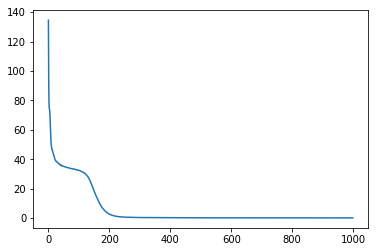

In [8]:
plt.plot(losses)

In [11]:
outp = np.array(sess.run(outputs, feed_dict={X: batch_x}))
outp.shape

(192, 128, 13)

In [13]:
batch_y.shape

(128, 192, 13)

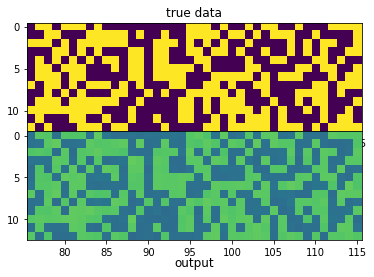

In [30]:
draw(batch_y[0, :, :], outp[:, 0, :])  # вывелся на рисунке, правда, кусочек, но не суть: сравнение правильного ответа и выхода

In [31]:
readings = np.array(sess.run(readings_log, feed_dict={X: batch_x}))
readings.shape

(192, 128, 80)

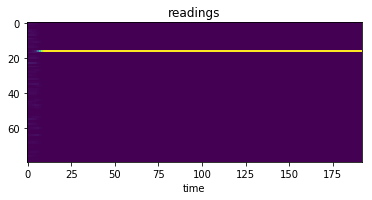

In [37]:
drawr(readings[:, 0, :])  # вектор считывания из истории

In [40]:
sess.close()

# Попробуем что-нить похитрее

Раньше final_lstm (последний слой) должен был просто выдать ту часть, которая пришла из памяти, теперь ещё надо и линейное преобразование сделать 

In [45]:
# the input data is 128+64 random binary vectors of dimension 13
# the output data has same dimensions; final 128 of vectors must be same rolled first 128 of input
def generate2():
    X = np.random.randint(0, 2, (128, 128+64, 13))
    X[:, 128:, :] = 0
    Y = np.zeros((128, 128+64, 13))
    Y[:, 64:, :] = np.roll(X[:, :128, :], 1, axis=2)
    return X, Y

In [46]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.4  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)

sess = tf.Session(config = config)
# Run the initializer
sess.run(init)

losses = []

In [47]:
training_steps = 1000
display_step = 100

for step in range(0, training_steps):
    batch_x, batch_y = generate2()
    
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    
    # Get Loss
    L = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
    losses.append(L)
    
    if step % display_step == 0:
        # Calculate batch loss and accuracy        
        print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(L))

print("Optimization Finished!")

Step 0, Minibatch Loss= 236.7795
Step 100, Minibatch Loss= 33.7293
Step 200, Minibatch Loss= 30.8055
Step 300, Minibatch Loss= 2.7598
Step 400, Minibatch Loss= 0.3649
Step 500, Minibatch Loss= 0.2067
Step 600, Minibatch Loss= 0.1512
Step 700, Minibatch Loss= 0.1236
Step 800, Minibatch Loss= 0.1013
Step 900, Minibatch Loss= 0.0856
Optimization Finished!


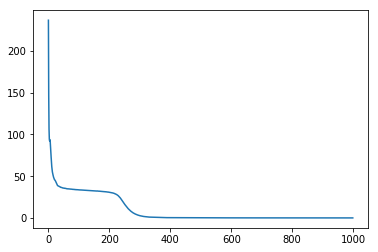

In [54]:
plt.plot(losses)

In [104]:
outp = np.array(sess.run(outputs, feed_dict={X: batch_x}))
outp.shape

(192, 128, 13)

In [105]:
batch_y.shape

(128, 192, 13)

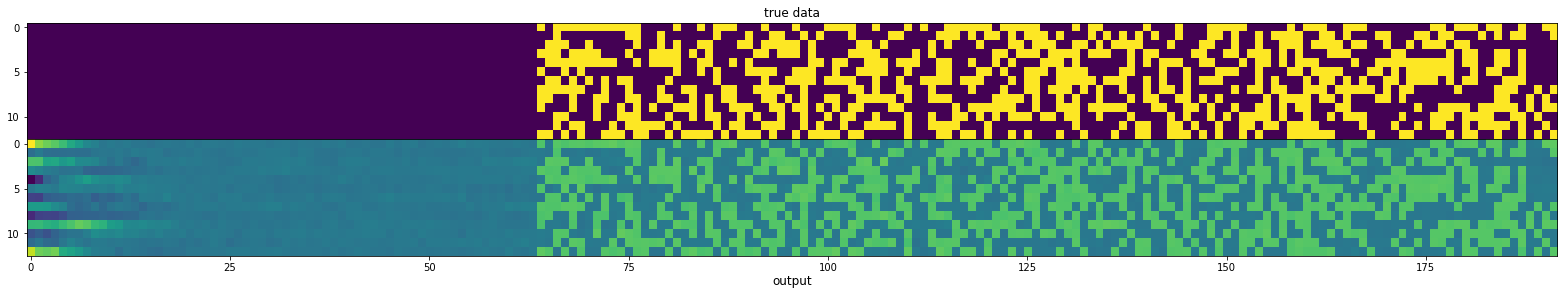

In [106]:
draw(batch_y[0, :, :], outp[:, 0, :])

In [107]:
readings = np.array(sess.run(readings_log, feed_dict={X: batch_x}))
readings.shape

(192, 128, 80)

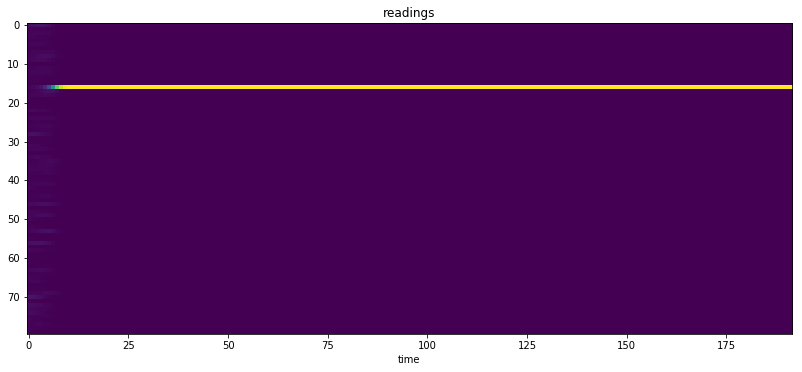

In [110]:
drawr(readings[:, 0, :])

ого, lstm умеет делать линейное преобразование!!! вау-вау!

In [ ]:
sess.close()

# Ещё хитрее

Теперь затестим выбор момента времени, откуда считывать - то есть что первые два слоя LSTM-а умеют понимать, когда откуда нужно считывать.

Здесь "насколько далеко из истории" берётся ответ, зависит от количества единиц в текущем входе. После этого взятый из истории вектор опять линейно преобразуется.

In [3]:
# the input data is 128+64 random binary vectors of dimension 13
# the output data has same dimensions: it's the rolled copy from history
# time, how far to go, depends on how much ones there are in current input

TIME_SHIFT = np.array([1, 2, 4, 8, 12, 16, 24, 28, 32, 36, 40, 48, 56, 64])
def generate3():
    X = np.random.randint(0, 2, (128, 128+64, 13))
    Y = np.zeros((128, 128+64, 13))
    
    times = TIME_SHIFT[X[:, 64:, :].sum(axis=2)]
    
    t, b, n = np.meshgrid(np.arange(128), np.arange(128), np.arange(13))
    t += 64 - times[:, :, None]
    
    Y[:, 64:, :] = np.roll(X[b, t, n], 1, axis=2)
    return X, Y

Проверка генератора на адекватность

In [4]:
Xdata, Ydata = generate3()
x, y = Xdata[13], Ydata[13]

In [5]:
np.array([y[65], x[65 - TIME_SHIFT[x[65].sum()]]], dtype=int)

array([[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [6]:
np.array([y[135], x[135 - TIME_SHIFT[x[135].sum()]]], dtype=int)

array([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]])

In [7]:
# Start training
config = tf.ConfigProto(log_device_placement=True)  # to output is variable on gpu or cpu
config.gpu_options.per_process_gpu_memory_fraction = 0.4  # BlasGEMM launch failed error fix (seems like not enopugh memory on gpu)

sess = tf.Session(config = config)
# Run the initializer
sess.run(init)

losses = []

In [8]:
training_steps = 1000
display_step = 100

for step in range(0, training_steps):
    batch_x, batch_y = generate3()
    
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    
    # Get Loss
    L = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
    losses.append(L)
    
    if step % display_step == 0:
        # Calculate batch loss and accuracy        
        print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(L))

print("Optimization Finished!")

Step 0, Minibatch Loss= 242.0948
Step 100, Minibatch Loss= 34.9697
Step 200, Minibatch Loss= 32.7084
Step 300, Minibatch Loss= 31.1007
Step 400, Minibatch Loss= 21.9189
Step 500, Minibatch Loss= 8.7983
Step 600, Minibatch Loss= 6.6984
Step 700, Minibatch Loss= 6.1168
Step 800, Minibatch Loss= 6.1238
Step 900, Minibatch Loss= 5.4136
Optimization Finished!


Идеального решения уже не находит...

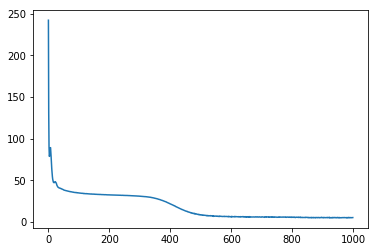

In [12]:
plt.plot(losses)

In [14]:
outp = np.array(sess.run(outputs, feed_dict={X: batch_x}))
outp.shape

(192, 128, 13)

In [15]:
batch_y.shape

(128, 192, 13)

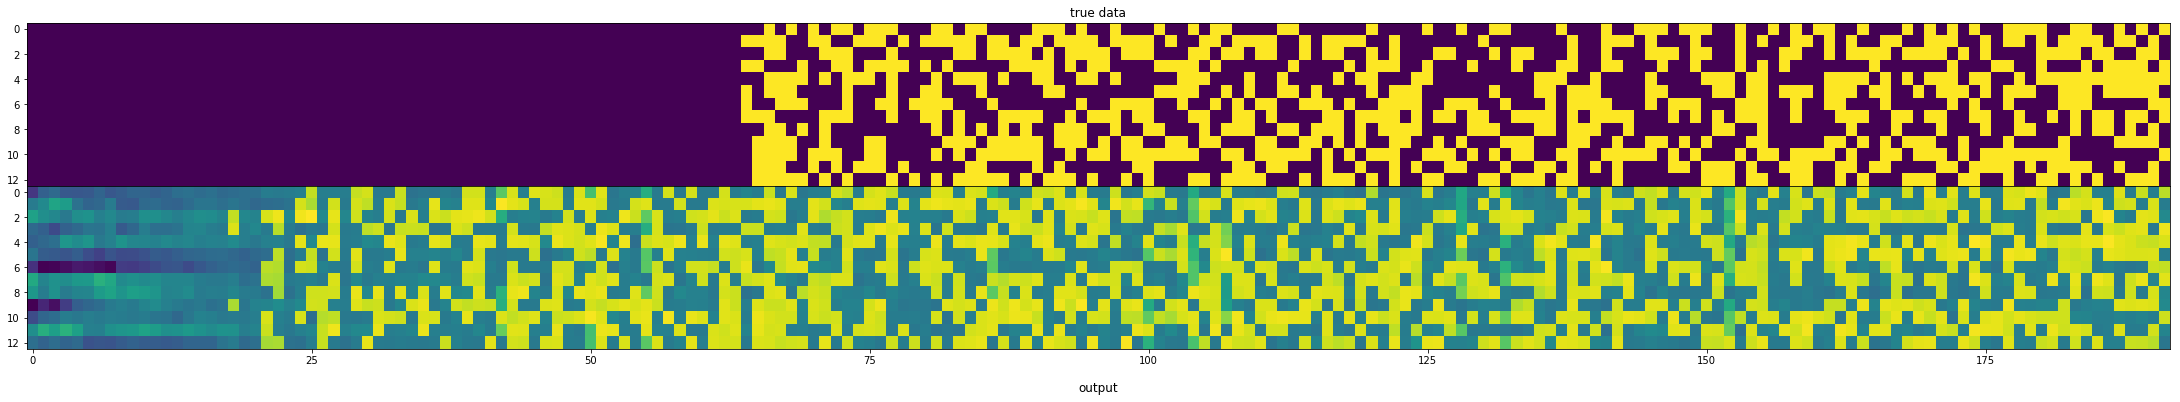

In [18]:
draw(batch_y[0, :, :], outp[:, 0, :])

In [19]:
readings = np.array(sess.run(readings_log, feed_dict={X: batch_x}))
readings.shape

(192, 128, 80)

Сравним вектор считывания из истории с "истинным" вектором. На графиках, правда, ось y надо "развернуть", но не суть

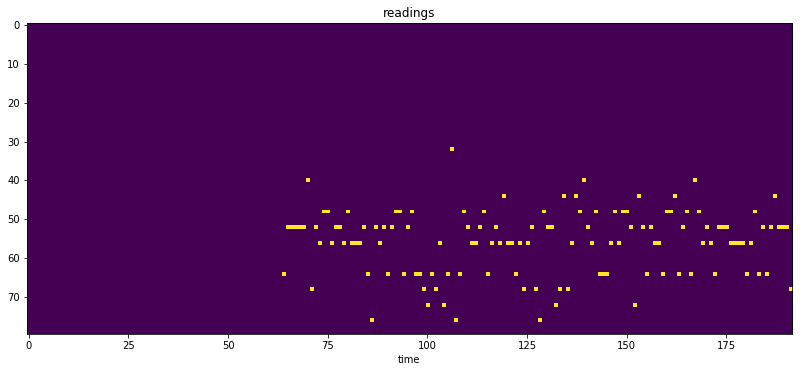

In [26]:
true_readings = np.zeros((128+64, 80))
true_readings[np.arange(64, 128+64), 80 - TIME_SHIFT[batch_x[0, 64:].sum(axis=1)]] = 1
drawr(true_readings)

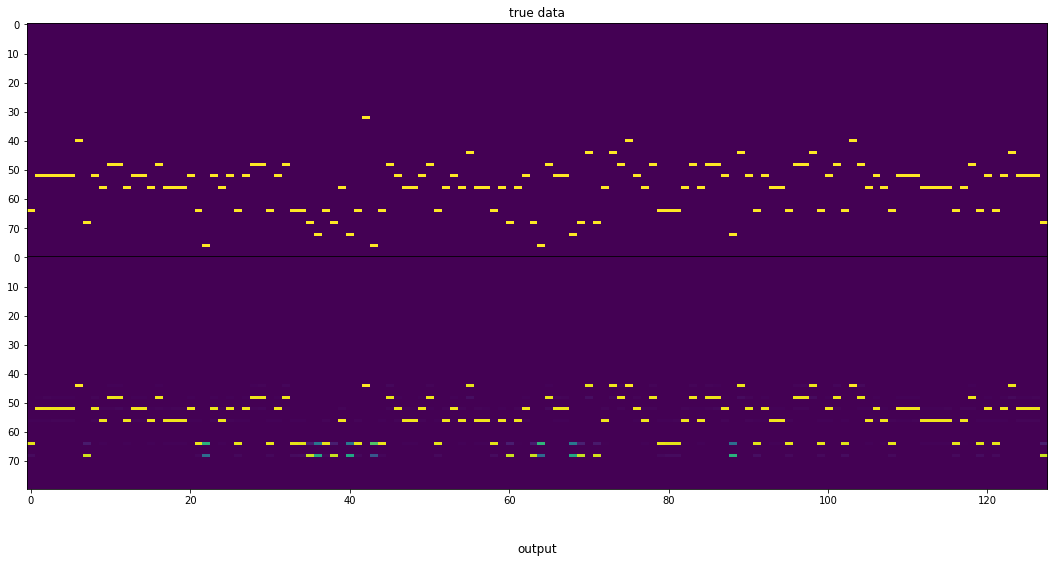

In [33]:
draw(true_readings[64:], readings[64:, 0, :], scalex=128.0 / 7, scaley=60.0 / 7)

Схожесть картинок с MIDI-данными СОВЕРШЕННО случайна. Совершенно. Или же?..

Возможно, стоит ещё пообучать?

In [34]:
training_steps = 1000
display_step = 100

for step in range(0, training_steps):
    batch_x, batch_y = generate3()
    
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
    
    # Get Loss
    L = sess.run(loss_op, feed_dict={X: batch_x, Y: batch_y})
    losses.append(L)
    
    if step % display_step == 0:
        # Calculate batch loss and accuracy        
        print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(L))

print("Optimization Finished!")

Step 0, Minibatch Loss= 5.4844
Step 100, Minibatch Loss= 5.2609
Step 200, Minibatch Loss= 5.0649
Step 300, Minibatch Loss= 5.3343
Step 400, Minibatch Loss= 5.1098
Step 500, Minibatch Loss= 5.0272
Step 600, Minibatch Loss= 5.2539
Step 700, Minibatch Loss= 5.2545
Step 800, Minibatch Loss= 5.0716
Step 900, Minibatch Loss= 5.1797
Optimization Finished!


In [45]:
outp = np.array(sess.run(outputs, feed_dict={X: batch_x}))

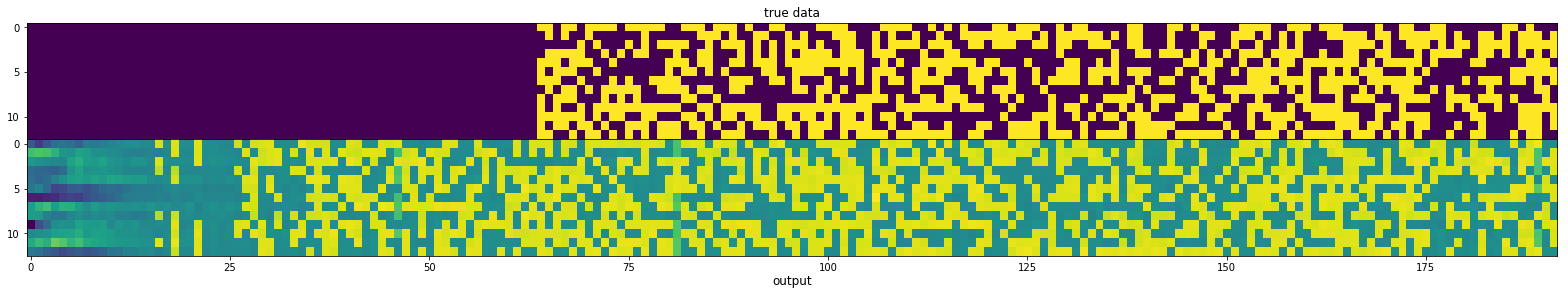

In [46]:
draw(batch_y[0, :, :], outp[:, 0, :])

In [47]:
outp = np.rollaxis(outp, 1)

In [48]:
ind_losses = (outp[:, 64:] - batch_y[:, 64:])**2
keys = batch_x.sum(axis=2)[:, 64:]

precedents = []
average_losses = []
for i in range(0, 14):
    precedents.append((keys == i).sum())
    average_losses.append(ind_losses[keys == i].sum() / precedents[-1])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


А посчитаем-ка средний лосс в зависимости от случая (от количества единиц на входе):

In [56]:
for i, pr, al in zip(np.arange(14), precedents, average_losses):
    print(i, " ones in input: ", pr, "precedents, average loss is ", al)

0  ones in input:  0 precedents, average loss is  nan
1  ones in input:  26 precedents, average loss is  4.81379446964
2  ones in input:  169 precedents, average loss is  4.96633011092
3  ones in input:  574 precedents, average loss is  4.78020507328
4  ones in input:  1405 precedents, average loss is  0.0198825607131
5  ones in input:  2538 precedents, average loss is  0.0190606337988
6  ones in input:  3512 precedents, average loss is  0.0206101177999
7  ones in input:  3469 precedents, average loss is  0.0237727983222
8  ones in input:  2555 precedents, average loss is  0.028482389047
9  ones in input:  1391 precedents, average loss is  0.0331932266643
10  ones in input:  557 precedents, average loss is  5.95965654431
11  ones in input:  154 precedents, average loss is  5.66335008211
12  ones in input:  30 precedents, average loss is  5.57386260011
13  ones in input:  4 precedents, average loss is  6.5549488468


Почти логичный результат, хотя граница неожиданно явная: редко встречающиеся случаи сеть, видимо, не улавливает, возможно потому что в этим моменты в памяти лежат очень похожие вектора в "других местах", и градиенты ведут не совсем туда. Хорошо то, что преобразование на последнем слое не мешает этим градиентам двигаться в правильном направлении.